# [NTDS'19] assignment 2: learning with graphs
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `25`
* Students:  `Erick Maraz`, `Lara Orlandic`, `Niccolo Stefanini`, `Valentin Viennot`

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

In this assignment you will experiment with the main concepts of spectral graph theory, as well as familizarize yourself with the main data science techniques for network data.

The assignment is made of three parts:
1. [Spectral Graph Theory](#sgt)
1. [Regularization on graphs with Graph Signal Processing](#gsp)
1. [Machine Learning on Graphs](#ml)

<a id='sgt'></a>
## Part I: Spectral Graph Theory
### Eigenvectors and eigenvalues

We will start by reviewing some of the main concepts in spectral graph theory and see some of its applications to dimensionality reduction and data clustering. To illustrate the main concepts we will use the standard two moon dataset.

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

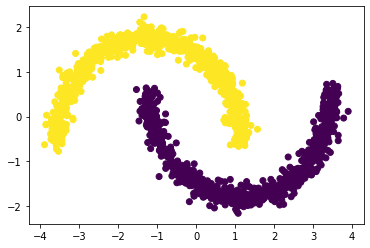

(2000, 2)

In [2]:
from pygsp.graphs import TwoMoons

G = TwoMoons(moontype='synthesized', N=2000)
X = G.coords
Y = G.labels.astype(int)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()
X.shape

#### Question 1: Graph construction
Build a similarity graph using the euclidean distance between data points.   
**Note:** Use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [3]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    distances = pdist(X, metric='euclidean')
    weights_list = np.exp(-pow(distances,2) / (2*pow(sigma,2)))
    weight_matrix = squareform(weights_list)
    adjacency = np.where(weight_matrix > epsilon, weight_matrix, 0)
    return adjacency

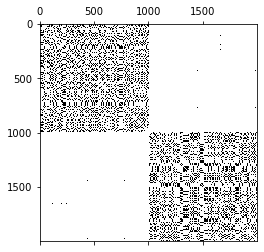

In [4]:
distances = pdist(X, metric='euclidean')
sigma_coeff = 0.5
sigma = sigma_coeff*np.mean(distances)
adjacency = epsilon_similarity_graph(X, sigma, epsilon=0.75)
plt.spy(adjacency)
plt.show()

(array([3439744.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   65826.,   70958.,   83012.,
         109600.,  230860.]),
 array([0.        , 0.05      , 0.09999999, 0.14999999, 0.19999999,
        0.24999999, 0.29999998, 0.34999998, 0.39999998, 0.44999998,
        0.49999997, 0.54999997, 0.59999997, 0.64999997, 0.69999996,
        0.74999996, 0.79999996, 0.84999996, 0.89999995, 0.94999995,
        0.99999995]),
 <a list of 20 Patch objects>)

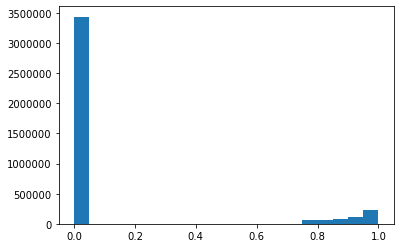

In [5]:
plt.hist(np.ravel(adjacency),bins=20)

In [6]:
sparsity = 1 - sum(sum(adjacency != 0))/np.prod(adjacency.shape)
print("Distribution clustered with {} sparsity coefficient".format(sparsity))

Distribution clustered with 0.859936 sparsity coefficient


How do you choose `sigma`?

In our code, sigma is a constant by which we multiply the mean distance between points. We chose 0.5 so that the kernel width would not be too large, and consequently the above histogram of weights of the adjacency matrix would be fairly evenly spread between 0 and 1 (not inclusive) before thresholding.

How do you choose the threshold `epsilon`?

Epsilon, which determines the threshold of distances below which we set the edge weights to zero, was chosen such that the graph is as sparse as possible while still being connected. We measured the graph sparsity as the proportion of zero values in the adjacency matrix. Increasing the threshold increases the sparsity of the graph and leads to better results in spectral clustering, but setting a threshold that is overly high leads to a disconnected graph. With a threshold of 0.75 we managed to obtain a graph with 85.85% with one connected component.

#### Question 2: Laplacian
Build the combinatorial and normalized graph laplacians for this dataset.

In [7]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    d = np.sum(adjacency, axis=0);
    D = np.diag(d);
    L = D - adjacency;
    if (normalize):
        D_sqrt = np.diag(np.sqrt(1./d))
        L = D_sqrt @ L @ D_sqrt
    return L

In [8]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

#### Question 3: Eigendecomposition

For both Laplacian matrices, compute the eigendecomposition $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. Make sure that the eigenvalues are ordered, i.e., $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$. 

Justify your choice of a solver for the eigendecomposition.

We use np.linalg.eigh because we have an undirected graph, which implies a symmetric adjacency matrix and therefore a symmetric laplacian. The eigh function uses some properties of symmetric matrices to optimize the computational time. Moreover, it returns ordered eigenvalues.

In [9]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, u = np.linalg.eigh(laplacian)
    return lamb, u

In [10]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

#### Question 4: Interpretation
We plot the sorted eigenvalues as a function of their index:

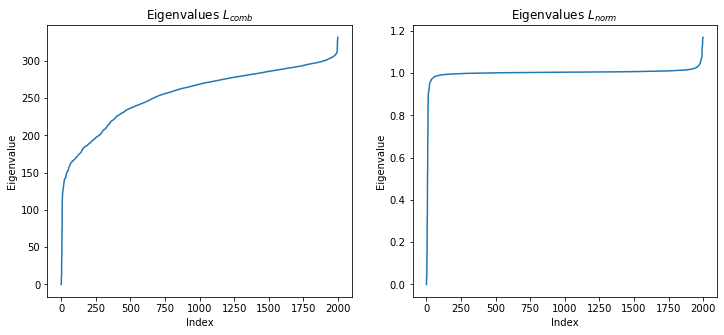

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

The lowest eigenvalue for both graphs is zero because the number of zero eigenvalues is equal to the number of connected components in the graph, and every graph has at least one connected component. The corresponding eigenvector for the non-normalized matrix is a constant vector. The first eigenvector of the non-normalized matrix is equal to $\frac{\sqrt{D}}{||\sqrt{D}||}$. From the code snippets below, we can see that both eigenvalues are practically zero, and the first eigenvectors are equal to their theoretical values.

In [12]:
#Non-normalized Laplacian
print(lamb_comb[0])
print(U_comb[:,0])

6.577244005938851e-14
[0.02236068 0.02236068 0.02236068 ... 0.02236068 0.02236068 0.02236068]


In [13]:
#Normalized Laplacian
print(lamb_norm[0])
print(U_norm[:,0])
D_sq = np.sqrt(np.diag(np.sum(adjacency, axis=0)));
theoretical_u0 = np.diag(D_sq)/np.linalg.norm(D_sq);
print(theoretical_u0)

-1.6376648934834672e-16
[-0.02301849 -0.02258039 -0.02217736 ... -0.02315864 -0.02366962
 -0.02371053]
[0.02301849 0.02258039 0.02217736 ... 0.02315864 0.02366962 0.02371053]


When filtering a signal or computing polynomials, which Laplacian provides the best numerical stability? Justify your answer.

The normalized Laplacian provides the best numerical stability because the eigenvalues are mostly close to 1, except for the first and last few eigenvalues. This provides more stability when computing weights for the polynomial representing the graph filter because the eigenvalues do not vary as much as in the combinatorial laplacian. If the eigenvalues are too big, it can make the weights vary significantly and therefore produce less stability when filtering the signal. Similarly with the ARMA filter, the solution only converges if  $\alpha \lambda_{max} < 1$, so the maximum eigenvalue should not be overly high.

#### Question 5: Connected components
The eigendecomposition provides an easy way to compute the number of connected components in the graph. Fill the following function:

In [14]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    n_components = sum(lamb<threshold)
    return n_components

Tune the parameters $\epsilon$ and $\sigma$ of the similarity graph so that the graph is connected. Otherwise, clustering would be too simple!

In [15]:
print(compute_number_connected_components(lamb_norm, threshold=0.0000001))

1


### Spectral clustering

Let us now see one application of spectral graph theory to clustering the two moon dataset.

#### Question 6: Baseline

As a baseline, let us first see how the simplest clustering algorithm, K-means, performs on this dataset. Use K-means to assign a cluster to each point.

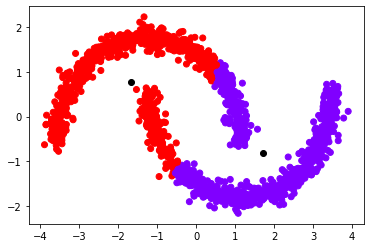

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

y_pred =  kmeans.labels_
plt.scatter(X[:, 0], X[:, 1], c=y_pred,cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black') #show centroids
plt.show()

K-means cannot find a good solution to this problem. Why?

The K-means algorithm determines the hyperplane between classes using the euclidean distance between points. However, since the points exist on a manifold, the euclidean distance does not accurately represent the distance between two points.

#### Question 7: Spectral clustering

As opposed to naive K-means, spectral clustering doesn't operate on the input space but on the eigenspace of the graph that represents the data. Implement spectral clustering. You can use 
[this tutorial](http://lasa.epfl.ch/teaching/lectures/ML_Phd/Notes/tutoSC.pdf).

In [17]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  KMeans(n_clusters=n_classes)
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.laplacian = compute_laplacian(adjacency, normalize=self.normalize)
        self.e, self.U = spectral_decomposition(self.laplacian)
        Y = self.U[:,:self.n_classes];
        if (self.normalize):
            Y = (Y.T / np.linalg.norm(Y, axis=1)).T
        self.clustering_method.fit(Y)
        y_pred =  self.clustering_method.predict(Y)
            
        return y_pred

Connected components: 1


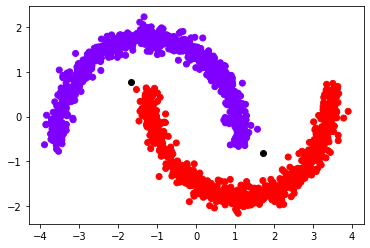

In [18]:
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-12))
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred =  spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black') #show centroids
plt.show()

#### Question 8: On your dataset

Can you think of another 2D dataset in which k-means would badly perform, but spectral clustering would not?
Construct it!
For this question you can import any dataset of your choice, for example from `sklearn.datasets` or `pygsp.graphs`, but you can also get creative and define something of your own. First, create and plot the dataset.

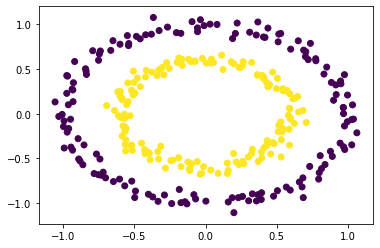

(300, 2)

In [19]:
from sklearn.datasets import make_circles

X,y = make_circles(300, noise=0.05, factor=0.6)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()
X.shape

Run K-means:

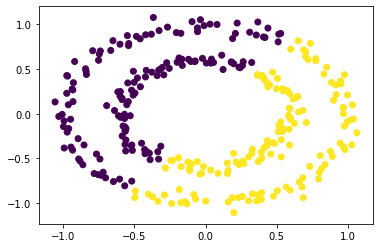

In [20]:
n_classes = 2
kmeans = KMeans(n_clusters=n_classes)
kmeans.fit(X)
y_pred =  kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

Create the similarity graph, and run spectral clustering with both the combinatorial and normalized Laplacian matrices:

Connected components: 1


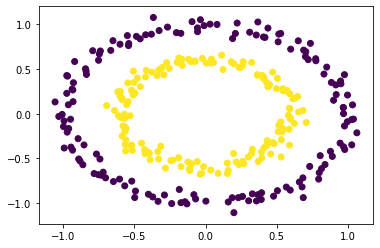

In [21]:
distances = pdist(X, metric='euclidean')
sigma_coeff = 0.25
sigma = sigma_coeff*np.mean(distances)
adjacency = epsilon_similarity_graph(X, sigma, epsilon=0.7) #If the matrix isn't sparse enough, spectral decomposition doesnt work
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-12))
spectral_clustering = SpectralClustering(n_classes=n_classes, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

Spectral clustering enables a separation between the inner and outer circles, since it discovers the underlying circular manifolds of the two components. K-means, on the other hand, only takes the euclidean distances between points into account when clustering points, so it essentially splits the circles in half.

### Dimensionality Reduction with Laplacian Eigenmaps

Most datasets are very high-dimensional, which means it can be very hard to understand their geometry. Fortunately, there exists multiple  techniques that can help us to reduce the dimensionality of the data, and allow us to visualize it. 

In this part of the assignment we will use MNIST to compare these techniques. Indeed, without dimensionality reduction it would be very difficult to answer questions like: are the different digits clustered together in different areas of space? 

But first, let's load our dataset:

In [22]:
from utils import load_mnist

X_mnist, y_mnist = load_mnist()
classes = np.unique(y_mnist)

#### Question 9: Laplacian eigenmaps

Most dimensionality reduction algorithms are constructed such that some property of the dataset remains invariant in the lower dimensional representation. Before implementing laplacian eigenmaps, can you say what property of the data does this algorithm preserve?

It preserves the local geometry between points.

Implement a function that uses Laplacian eigenmaps to do dimensionality reduction.

In [23]:
def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    # Your code here
    adjacency = epsilon_similarity_graph(X, sigma, epsilon)
    laplacian = compute_laplacian(adjacency, normalize)
    lamb, U = spectral_decomposition(laplacian)
    connected_comps = compute_number_connected_components(lamb, threshold=1e-12)
    if (connected_comps != 1):
        print("Warning!! Graph is not connected")
    solution = U[:,1:(dim+1)]
    return solution

Use this function to visualize MNIST in 2D. Feel free to play with the different parameters.

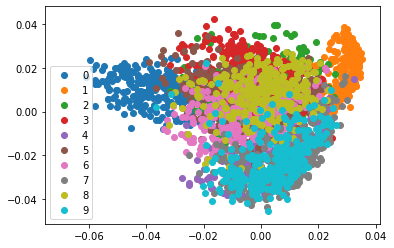

In [24]:
dim = 2
distances = pdist(X_mnist, metric='euclidean')
sigma_coeff = 0.75
sigma = sigma_coeff*np.mean(distances)
eigenmaps = laplacian_eigenmaps(X_mnist,dim,sigma,epsilon=0.1,normalize=True)
for i in classes:
            mask = y_mnist == i
            plt.scatter(eigenmaps[mask, 0], eigenmaps[mask, 1], label=i)
plt.legend()
plt.show()

Visualize MNIST in 3D:

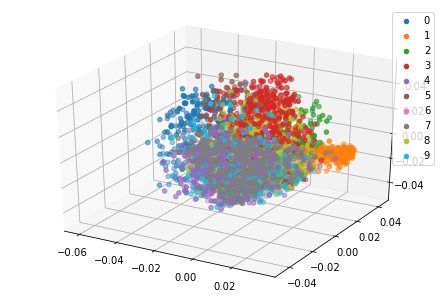

In [25]:
dim = 3
sigma_coeff = 0.8
sigma = sigma_coeff*np.mean(distances)
eigenmaps = laplacian_eigenmaps(X_mnist,dim,sigma,epsilon=0.1,normalize=True)
fig = plt.figure()
ax = Axes3D(fig)
for i in classes:
            mask = y_mnist == i
            ax.scatter(eigenmaps[mask,0],eigenmaps[mask,1],eigenmaps[mask,2], label=i)
plt.legend()
plt.show()

#### Question 10: Comparison with other methods  
We provide the visualization of MNIST with other methods:

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# This cell can take a few minutes to run
run_this_cell = False

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        for i in classes:
            mask = y_mnist == i
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_mnist == i
            ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In a few words, what are the principles guiding the design of each method? Compare their results.

* Principal component analysis projects the data onto the covariance matrix to determine which linear subspaces maximize the data variance, and then only use the dimensions that show significant variance. It performs the worst out of the four methods in terms of separating the letters because it only considers linear combinations of features, which may not accurately describe all of the curvy letters in the data.


* Isomap is a nonlinear method that performs better than PCA, as we can see more distinct data clusters in its 3D graph than in that of PCA. This method preserves the local distances between points by computing the kNN graph and setting its weights equal to the distances between points. Then, the shortest path matrix is computed and MDS is run on this matrix to reduce the dimensionality of the graph considering only the local point information. This method performs well for our purposes but it may depict a skewed manifold if k is too large.


* Similarly to isomaps, laplacian eigenmaps aim to preserve the local geometry of the data. They extract the first k nontrivial eigenvectors of the graph laplacian, which are essentially smoothing functions over the graph, to cluser the data. It performs reasonably well in clusering the data.


* tSNE is a dimensionality reduction method based on Gaussian mixture models that aims to solve the problem of cluster crowding that the aforementioned dimensionality reduction algorithms possess. This method performs the best, since we can see clearly defined clusters for each number.

<a id='gsp'></a>
## Part II: Regularization on graphs with Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing and regularization on graphs in general. From now on, you can only use the following libraries as well as the functions that you implemented in the previous parts.

In [27]:
import pandas as pd
import numpy as np
from pygsp.graphs import Bunny

In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [28]:
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

We will use the following function to plot our signals on this graph.

In [29]:
def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)

    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if x is not None:
        fig.colorbar(p)

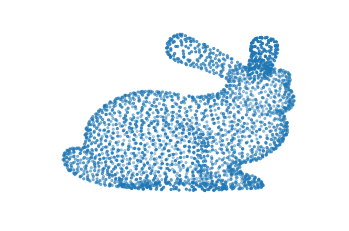

In [30]:
plt.subplot(111, projection='3d')
plot_bunny()

#### Question 11: Graph frequencies

Let us start by constructing the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [31]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)

Plot the eigenvalues.

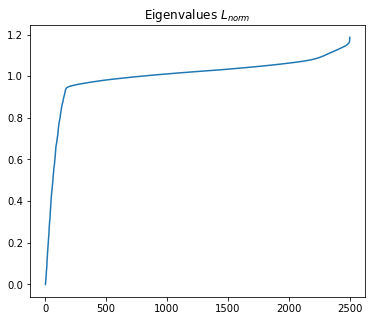

In [32]:
plt.figure(figsize=(6, 5))
plt.plot(lam)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

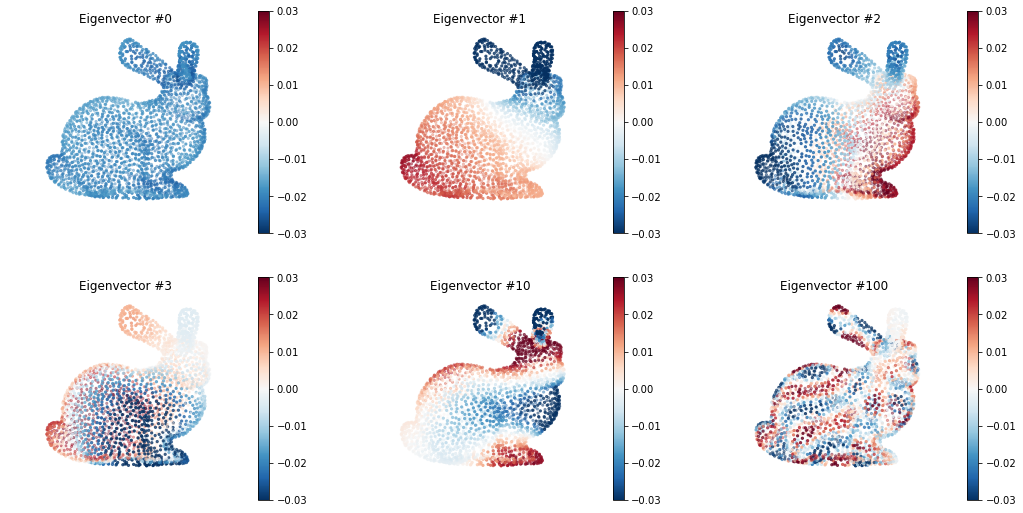

In [33]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

What can you say in terms of the variation (smoothness) of these signals? How can the smoothness of a signal be measured?

The eigenvectors of the graph signal are ordered from most to least smooth. The quadratic form of the Laplacian of a signal $f$, $f^TLf$, tells us how smooth a signal is. Since $f$ in this case is each eigenvector, the quadratic Laplacian corresponds to its corresponding eigenvalue. This means that the eigenvalues of the graph are inversely proportional to the smoothness.

#### Question 12: Graph Fourier Transform

Create a function to compute the Graph Fourier Transform (GFT) of a graph signal and its inverse.
**Note**: You can assume that you have internal access to the eigendecomposition (`U` and `lam`) of the laplacian.

In [34]:
def GFT(signal: np.ndarray):
    return U.T @ signal;

def iGFT(fourier_coefficients: np.ndarray):
    return U @ fourier_coefficients

Now, let's create a graph signal:

/opt/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


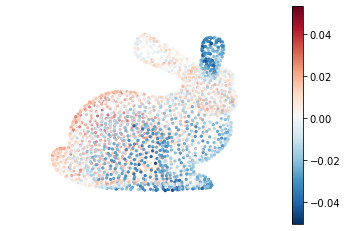

In [35]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3*noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)])

and plot its graph spectrum:

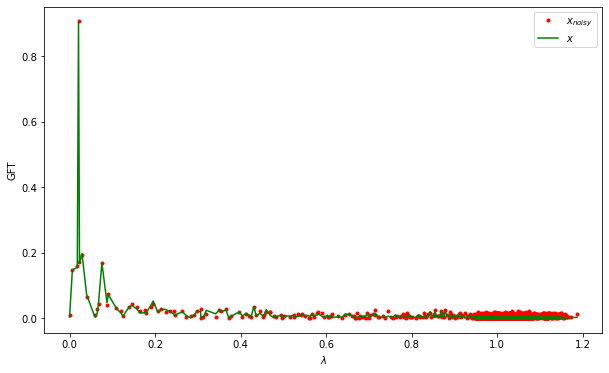

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(lam, np.abs(GFT(x_noisy)), 'r.') 
plt.plot(lam, np.abs(GFT(x)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x_{noisy}$', '$x$'])

#### Question 13: Graph filters

We will try to extract the signal from the noise using graph filters. Let us start by creating three ideal graph filters.

In [37]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

Additionally, create the ideal graph filter that implements the solution of Tikhonov regularization.

In [38]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1+ alpha*lam)

Let's plot the spectral responses:

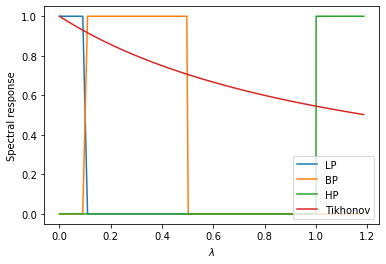

In [39]:
plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')

Create a function to filter a signal given an ideal graph filter

In [40]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    return iGFT(np.diag(spectral_response) @ GFT(x))

In [41]:
x_lp = ideal_graph_filter(x_noisy,ideal_lp)
x_lp.shape

(2503,)

Let us visualize the results:

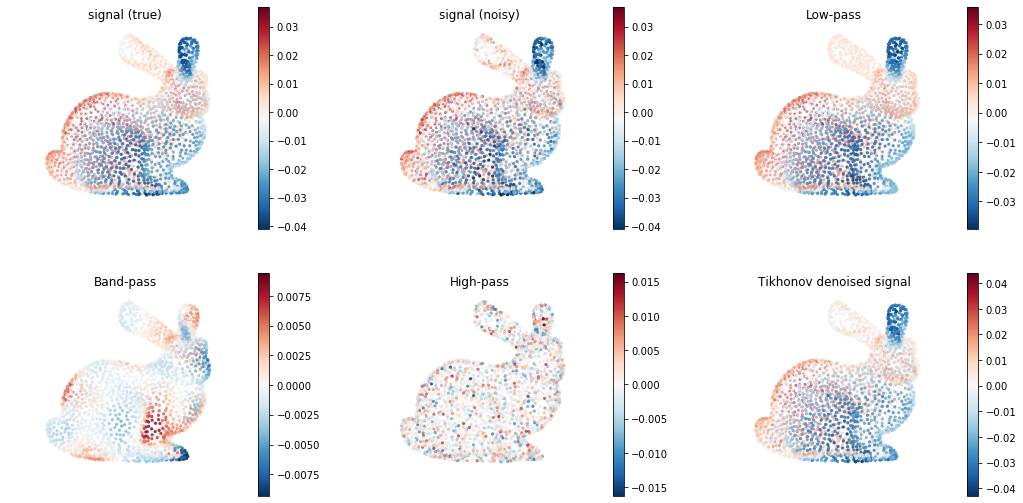

In [42]:
x_lp = ideal_graph_filter(x_noisy,ideal_lp)
x_bp = ideal_graph_filter(x_noisy,ideal_bp)
x_hp = ideal_graph_filter(x_noisy,ideal_hp)
x_tk = ideal_graph_filter(x_noisy,ideal_tk)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

How would you link to the observations you made before about the spectral decomposition of the laplacian?
Also, judging from the results, what type of model prior do you think Tikhonov regularization enforces?

The spectral decomposition of the laplacian arranges the eigenvalues from smoothest to least smooth, and we see from the Fourier Transforms of the clean and noisy graph signals that the added noise contributes high-frequency components to the spectrum of the graph. Therefore, by setting the high-frequency eigenvalues of the graph to zero in the ideal lowpass case, we are effectively removing the noise and producing a smoother graph. Tikhonov regularization most closely resembles the ideal lowpass filter, which we can see from its spectral response, since it suppresses higher values of lambda. However, in cases where there is lots of high-frequency noise, the Tikhonov filter may not perform as well as the lowpass because it does not completely eliminate high-frequency noise. Conversely, the Tikhonov regularization may be beneficial because it preserves the signal spectral components at high frequencies, whereas the lowpass filter suppresses all of this information.

#### Question 14: Polynomial graph filters

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
(\lambda_0)^k &\dots & 0\\
\vdots & \ddots & \vdots\\
0 & \dots & (\lambda_N)^k
\end{bmatrix} U^T.
$$

This means that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k.$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right).$$

With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Implement a function to find the coefficients of a polynomial that approximates a given ideal filter.
**Hint:** `np.vander` and `np.linalg.lstsq`.

In [43]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    V = np.vander(lam,order)
    return np.linalg.solve(V.T @ V, V.T @ spectral_response);

Implement a function to compute the frequency response of that filter.

In [44]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    P = len(coeff);
    V = np.vander(lam,P)
    return V @ coeff
    

Let us fit the Tikhonov ideal filter with several polynomials of different order.

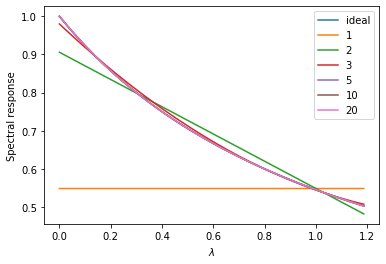

In [45]:
plt.plot(lam, ideal_tk)
orders = [1, 2, 3, 5, 10, 20]
for order in orders:    
    coeff_tk = fit_polynomial(lam, order, ideal_tk)
    plt.plot(lam, polynomial_graph_filter_response(coeff_tk, lam))

plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
orders.insert(0,"ideal")
plt.legend(orders)

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [46]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """ 
    out = np.zeros(laplacian.shape)
    for i in range(len(coeff)):
        out += coeff[i]*np.linalg.matrix_power(laplacian,i)
    return out

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [47]:
order =  5
coeff_tk = fit_polynomial(lam, order, ideal_tk)
coeff_tk = np.flipud(coeff_tk)
g_tk = polynomial_graph_filter(coeff_tk, laplacian)

#### Question 15: ARMA filter

As you have seen in class, polynomial graph filters are only one of the ways in which you can approximate ideal graph filters. 
In this sense, ARMA filters are a natural way to implement Tikhonov denoising on graphs.
Let us recall the general solution of the Tikhonov regularized denoising problem 

$$y=(I+\alpha L)^{-1}x. $$

With a little bit of algebra manipulation we can rewrite this expression as
$$
    y = -\alpha L y + x,
$$
from which we can derive the iterative algorithm
$$
    y_k = -\alpha L y_{k-1} + x\qquad k=1,2,\dots
$$
which is guaranteed to converge as long as $\alpha \lambda_{max} < 1$.

Implement the ARMA version of Tikhonov regularization.

In [48]:
def arma_tikhonov(x: np.ndarray, laplacian: np.ndarray, alpha: float, max_iter=50):
    """ Return an array of the same shape as x."""
    y = x;
    for k in range(max_iter):
        y = -(alpha*laplacian @ y) + x
    return y

Filter the previous noisy graph signal with the polynomial and ARMA approximations of the ideal Tikhonov filter.

In [49]:
x_tk_polynomial =  g_tk @ x_noisy
x_tk_arma = arma_tikhonov(x_noisy, laplacian, alpha)

Let us compare with the previous version.

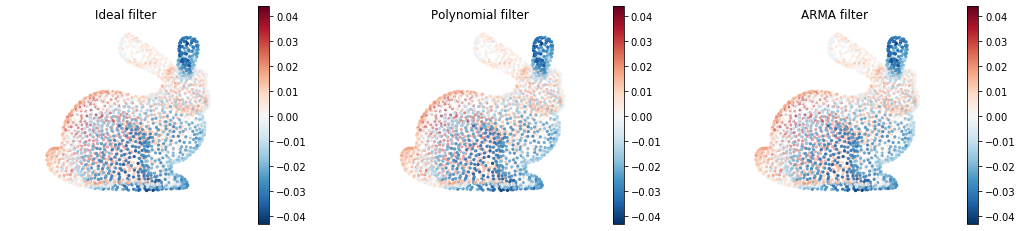

In [50]:
plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(x_tk, title='Ideal filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(132, projection='3d')
plot_bunny(x_tk_polynomial, title='Polynomial filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(133, projection='3d')
plot_bunny(x_tk_arma, title='ARMA filter', vlim=[min(x_tk), max(x_tk)])

<a id='ml'></a>
## Part III: Machine Learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [51]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library (DGL).

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph.
Our task is to design a classifier that uses these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs.
We assume that we know to which scientific field a small subset of the papers belongs (the ones contained in `train_mask`).
The goal is to predict to which field the other papers belong, using both the citation graph and the bag-of-word representation of each paper.

In [52]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) # Mask of nodes selected for training
val_mask = torch.BoolTensor(cora.val_mask)     # Mask of nodes selected for validation
test_mask = torch.BoolTensor(cora.test_mask)   # Mask of nodes selected for testing

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))
n_nodes = adjacency.shape[0]

For this exercise we will use the normalized laplacian.

In [53]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

#### Question 16: Logistic regression

The simplest classification method consists in ignoring the citation graph and trying to classify the papers using only the features.
In this case, the problem is viewed as a standard classification task.
To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them.
To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set.
And finally, we will test our classifier on the rest of the nodes.
**Hint:** use `sklearn.linear_model.LogisticRegression`.

In [54]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [55]:
# Fit a logistic regression model
# Your code here
def create_rg(
    random_state=0,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=200,
    C=1e6,
    warm_start=True,
):
    return LogisticRegression(
        random_state=random_state,
        solver=solver,
        multi_class=multi_class,
        max_iter=max_iter,
        C=C,
        warm_start=warm_start
    )
print(f'[Fun fact] Random accuracy would be: {1/n_classes}')

[Fun fact] Random accuracy would be: 0.14285714285714285


In [56]:
# Fit a logistic regression model
# Your code here
#clf = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(train_features, train_labels)
clf = create_rg(C=1e3, max_iter=300).fit(train_features, train_labels)

In [57]:
train_acc =  clf.score(train_features,train_labels)
val_acc =  clf.score(val_features,val_labels)
test_acc =  clf.score(test_features,test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.5733 | Test accuracy 0.5750


#### Question 17: Handcrafted graph filters

That's not a bad start! Now, let's try to improve a bit the results by taking into account the graph structure using tools from GSP. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

However, before we start, what hypothesis can you make on the spectral properties of the denoised signal?

*Your answer here*  

Our first hypothesis was that a paper citing another should have similar features (i.e. same subject and keywords). We can therefore make a hypothesis about our denoised data: it contains low-frequency spectral components. That is to say that the data doesn't change locally, or changes slowly.

Let's then assume that the noise is high frequency graph signals. Therefore, a low-pass filter should be adapted.

Based on this prior, design an ideal filter response that you believe could enhance important features of the graph. 

**Note:** you just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note:** finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [58]:
ideal_filter = np.ones((n_nodes,))

ideal_filter[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
## [filtered] Train accuracy 0.8714 | Validation accuracy 0.8267 | Test accuracy 0.8150

#alpha = 0.99 / np.max(lam)
#ideal_filter =  1/(1+ alpha*lam)
## [filtered] Train accuracy 1.0000 | Validation accuracy 0.6967 | Test accuracy 0.6740

features_filtered = ideal_graph_filter(features.numpy(), ideal_filter)

train_filtered_features = features_filtered[train_mask, :]
val_filtered_features = features_filtered[val_mask, :]
test_filtered_features = features_filtered[test_mask, :]

lr_filtered = create_rg(max_iter=300, C=1e3)
lr_filtered = lr_filtered.fit(train_filtered_features, train_labels)

train_acc = lr_filtered.score(train_filtered_features, train_labels)
val_acc = lr_filtered.score(val_filtered_features, val_labels)
test_acc = lr_filtered.score(test_filtered_features, test_labels)

print('[filtered] Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

[filtered] Train accuracy 0.8714 | Validation accuracy 0.8300 | Test accuracy 0.8160


Choose a filter order to approximate your filter using laplacian polynomials.

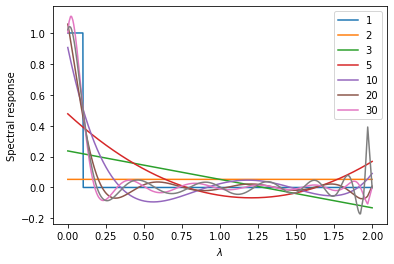

In [59]:
plt.plot(lam, ideal_filter)
orders = [1, 2, 3, 5, 10, 20, 30]
for order in orders:    
    coeff_tk = fit_polynomial(lam, order, ideal_filter)
    plt.plot(lam, polynomial_graph_filter_response(coeff_tk, lam))

plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(orders)

In [60]:
order = 10
coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

Let's plot the frequency response of your spectral template and its polynomial approximation.

Text(0, 0.5, 'Spectral response')

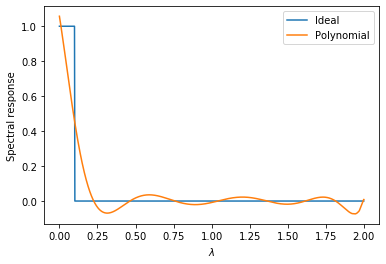

In [61]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

Now, let's create the new features.

In [62]:
filtered_features = graph_filter @ features.numpy()

train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train another logistic regression classifier on the new features. Remember to play with the regularization parameters to achieve a well performing model.

In [63]:
# Your code here
logreg2 = create_rg(max_iter=100, C=1e1).fit(train_features, train_labels)

Evaluate your model.

In [64]:
train_acc = logreg2.score(train_features,train_labels) #something is wrong here, it keeps giving me the same values
val_acc = logreg2.score(val_features,val_labels)
test_acc = logreg2.score(test_features,test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.9500 | Validation accuracy 0.7967 | Test accuracy 0.8100


#### Question 18: Graph convolutional networks

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method.

In this exercise, we will follow the same classification pipeline as above, but instead of hand-crafting our filter we will let `PyTorch` find the coefficients for us using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful if you want to solve some learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [65]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model.

In [66]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Choose the training parameters.

In [67]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

And train the classifier end to end.

In [68]:
graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/opt/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 1.9459 | Val Accuracy 0.2667
Epoch 00001 | Time(s) nan | Train Loss 1.9221 | Val Accuracy 0.2533
Epoch 00002 | Time(s) nan | Train Loss 1.8533 | Val Accuracy 0.2467
Epoch 00003 | Time(s) 0.0193 | Train Loss 1.7058 | Val Accuracy 0.2700
Epoch 00004 | Time(s) 0.0190 | Train Loss 1.4878 | Val Accuracy 0.2900
Epoch 00005 | Time(s) 0.0191 | Train Loss 1.3438 | Val Accuracy 0.2967
Epoch 00006 | Time(s) 0.0193 | Train Loss 1.0504 | Val Accuracy 0.3067
Epoch 00007 | Time(s) 0.0194 | Train Loss 1.1285 | Val Accuracy 0.3167
Epoch 00008 | Time(s) 0.0192 | Train Loss 0.8329 | Val Accuracy 0.3200
Epoch 00009 | Time(s) 0.0197 | Train Loss 0.9067 | Val Accuracy 0.3167
Epoch 00010 | Time(s) 0.0199 | Train Loss 0.8401 | Val Accuracy 0.3133
Epoch 00011 | Time(s) 0.0201 | Train Loss 1.0514 | Val Accuracy 0.3133
Epoch 00012 | Time(s) 0.0201 | Train Loss 1.1378 | Val Accuracy 0.3300
Epoch 00013 | Time(s) 0.0200 | Train Loss 1.1666 | Val Accuracy 0.3200
Epoch 00014 | T

Epoch 00116 | Time(s) 0.0202 | Train Loss 0.1922 | Val Accuracy 0.4933
Epoch 00117 | Time(s) 0.0202 | Train Loss 0.2064 | Val Accuracy 0.4933
Epoch 00118 | Time(s) 0.0202 | Train Loss 0.2180 | Val Accuracy 0.4900
Epoch 00119 | Time(s) 0.0202 | Train Loss 0.3112 | Val Accuracy 0.4867
Epoch 00120 | Time(s) 0.0202 | Train Loss 0.1790 | Val Accuracy 0.4767
Epoch 00121 | Time(s) 0.0201 | Train Loss 0.1252 | Val Accuracy 0.4733
Epoch 00122 | Time(s) 0.0201 | Train Loss 0.1799 | Val Accuracy 0.4800
Epoch 00123 | Time(s) 0.0201 | Train Loss 0.1971 | Val Accuracy 0.4833
Epoch 00124 | Time(s) 0.0201 | Train Loss 0.1703 | Val Accuracy 0.4833
Epoch 00125 | Time(s) 0.0201 | Train Loss 0.1530 | Val Accuracy 0.4833
Epoch 00126 | Time(s) 0.0201 | Train Loss 0.1862 | Val Accuracy 0.5067
Epoch 00127 | Time(s) 0.0201 | Train Loss 0.1641 | Val Accuracy 0.5200
Epoch 00128 | Time(s) 0.0201 | Train Loss 0.2754 | Val Accuracy 0.5233
Epoch 00129 | Time(s) 0.0201 | Train Loss 0.2412 | Val Accuracy 0.5433
Epoch 

Epoch 00233 | Time(s) 0.0200 | Train Loss 0.0423 | Val Accuracy 0.7133
Epoch 00234 | Time(s) 0.0200 | Train Loss 0.1385 | Val Accuracy 0.7200
Epoch 00235 | Time(s) 0.0200 | Train Loss 0.1209 | Val Accuracy 0.7233
Epoch 00236 | Time(s) 0.0200 | Train Loss 0.0649 | Val Accuracy 0.7267
Epoch 00237 | Time(s) 0.0200 | Train Loss 0.0521 | Val Accuracy 0.7233
Epoch 00238 | Time(s) 0.0200 | Train Loss 0.0492 | Val Accuracy 0.7233
Epoch 00239 | Time(s) 0.0200 | Train Loss 0.0792 | Val Accuracy 0.7233
Epoch 00240 | Time(s) 0.0200 | Train Loss 0.0556 | Val Accuracy 0.7233
Epoch 00241 | Time(s) 0.0199 | Train Loss 0.0382 | Val Accuracy 0.7200
Epoch 00242 | Time(s) 0.0199 | Train Loss 0.0947 | Val Accuracy 0.7200
Epoch 00243 | Time(s) 0.0199 | Train Loss 0.0524 | Val Accuracy 0.7267
Epoch 00244 | Time(s) 0.0199 | Train Loss 0.0449 | Val Accuracy 0.7200
Epoch 00245 | Time(s) 0.0199 | Train Loss 0.0579 | Val Accuracy 0.7200
Epoch 00246 | Time(s) 0.0199 | Train Loss 0.1111 | Val Accuracy 0.7200
Epoch 

Epoch 00353 | Time(s) 0.0197 | Train Loss 0.0456 | Val Accuracy 0.7533
Epoch 00354 | Time(s) 0.0197 | Train Loss 0.0419 | Val Accuracy 0.7567
Epoch 00355 | Time(s) 0.0197 | Train Loss 0.0921 | Val Accuracy 0.7533
Epoch 00356 | Time(s) 0.0197 | Train Loss 0.0557 | Val Accuracy 0.7533
Epoch 00357 | Time(s) 0.0197 | Train Loss 0.0482 | Val Accuracy 0.7567
Epoch 00358 | Time(s) 0.0197 | Train Loss 0.0400 | Val Accuracy 0.7567
Epoch 00359 | Time(s) 0.0197 | Train Loss 0.0522 | Val Accuracy 0.7567
Epoch 00360 | Time(s) 0.0197 | Train Loss 0.0915 | Val Accuracy 0.7633
Epoch 00361 | Time(s) 0.0197 | Train Loss 0.0809 | Val Accuracy 0.7667
Epoch 00362 | Time(s) 0.0197 | Train Loss 0.0685 | Val Accuracy 0.7700
Epoch 00363 | Time(s) 0.0197 | Train Loss 0.0412 | Val Accuracy 0.7733
Epoch 00364 | Time(s) 0.0197 | Train Loss 0.0600 | Val Accuracy 0.7800
Epoch 00365 | Time(s) 0.0197 | Train Loss 0.0816 | Val Accuracy 0.7767
Epoch 00366 | Time(s) 0.0197 | Train Loss 0.0722 | Val Accuracy 0.7733
Epoch 

Epoch 00470 | Time(s) 0.0196 | Train Loss 0.0559 | Val Accuracy 0.7700
Epoch 00471 | Time(s) 0.0196 | Train Loss 0.0704 | Val Accuracy 0.7667
Epoch 00472 | Time(s) 0.0196 | Train Loss 0.1044 | Val Accuracy 0.7733
Epoch 00473 | Time(s) 0.0196 | Train Loss 0.0616 | Val Accuracy 0.7767
Epoch 00474 | Time(s) 0.0196 | Train Loss 0.0263 | Val Accuracy 0.7767
Epoch 00475 | Time(s) 0.0196 | Train Loss 0.0242 | Val Accuracy 0.7733
Epoch 00476 | Time(s) 0.0196 | Train Loss 0.0159 | Val Accuracy 0.7733
Epoch 00477 | Time(s) 0.0196 | Train Loss 0.0958 | Val Accuracy 0.7767
Epoch 00478 | Time(s) 0.0196 | Train Loss 0.0501 | Val Accuracy 0.7733
Epoch 00479 | Time(s) 0.0196 | Train Loss 0.0856 | Val Accuracy 0.7700
Epoch 00480 | Time(s) 0.0196 | Train Loss 0.0278 | Val Accuracy 0.7733
Epoch 00481 | Time(s) 0.0196 | Train Loss 0.0358 | Val Accuracy 0.7700
Epoch 00482 | Time(s) 0.0196 | Train Loss 0.0268 | Val Accuracy 0.7733
Epoch 00483 | Time(s) 0.0196 | Train Loss 0.0680 | Val Accuracy 0.7733
Epoch 

Epoch 00589 | Time(s) 0.0196 | Train Loss 0.0349 | Val Accuracy 0.7767
Epoch 00590 | Time(s) 0.0196 | Train Loss 0.0094 | Val Accuracy 0.7733
Epoch 00591 | Time(s) 0.0196 | Train Loss 0.0127 | Val Accuracy 0.7733
Epoch 00592 | Time(s) 0.0196 | Train Loss 0.0377 | Val Accuracy 0.7700
Epoch 00593 | Time(s) 0.0196 | Train Loss 0.0613 | Val Accuracy 0.7767
Epoch 00594 | Time(s) 0.0196 | Train Loss 0.0508 | Val Accuracy 0.7833
Epoch 00595 | Time(s) 0.0196 | Train Loss 0.0421 | Val Accuracy 0.7800
Epoch 00596 | Time(s) 0.0196 | Train Loss 0.0409 | Val Accuracy 0.7767
Epoch 00597 | Time(s) 0.0196 | Train Loss 0.0126 | Val Accuracy 0.7800
Epoch 00598 | Time(s) 0.0196 | Train Loss 0.0489 | Val Accuracy 0.7833
Epoch 00599 | Time(s) 0.0196 | Train Loss 0.0238 | Val Accuracy 0.7867
Epoch 00600 | Time(s) 0.0196 | Train Loss 0.0429 | Val Accuracy 0.7867
Epoch 00601 | Time(s) 0.0196 | Train Loss 0.0262 | Val Accuracy 0.7867
Epoch 00602 | Time(s) 0.0196 | Train Loss 0.0146 | Val Accuracy 0.7900
Epoch 

Epoch 00707 | Time(s) 0.0196 | Train Loss 0.0292 | Val Accuracy 0.8033
Epoch 00708 | Time(s) 0.0196 | Train Loss 0.0087 | Val Accuracy 0.8133
Epoch 00709 | Time(s) 0.0196 | Train Loss 0.0764 | Val Accuracy 0.8133
Epoch 00710 | Time(s) 0.0196 | Train Loss 0.0192 | Val Accuracy 0.8100
Epoch 00711 | Time(s) 0.0196 | Train Loss 0.1317 | Val Accuracy 0.8067
Epoch 00712 | Time(s) 0.0196 | Train Loss 0.0171 | Val Accuracy 0.8033
Epoch 00713 | Time(s) 0.0196 | Train Loss 0.0455 | Val Accuracy 0.8033
Epoch 00714 | Time(s) 0.0196 | Train Loss 0.0884 | Val Accuracy 0.8067
Epoch 00715 | Time(s) 0.0196 | Train Loss 0.0520 | Val Accuracy 0.8033
Epoch 00716 | Time(s) 0.0196 | Train Loss 0.0291 | Val Accuracy 0.8033
Epoch 00717 | Time(s) 0.0196 | Train Loss 0.0340 | Val Accuracy 0.8000
Epoch 00718 | Time(s) 0.0196 | Train Loss 0.0555 | Val Accuracy 0.7967
Epoch 00719 | Time(s) 0.0196 | Train Loss 0.0406 | Val Accuracy 0.7967
Epoch 00720 | Time(s) 0.0196 | Train Loss 0.0819 | Val Accuracy 0.8000
Epoch 

Epoch 00825 | Time(s) 0.0196 | Train Loss 0.0841 | Val Accuracy 0.7733
Epoch 00826 | Time(s) 0.0196 | Train Loss 0.0672 | Val Accuracy 0.7800
Epoch 00827 | Time(s) 0.0196 | Train Loss 0.0555 | Val Accuracy 0.7867
Epoch 00828 | Time(s) 0.0196 | Train Loss 0.0431 | Val Accuracy 0.7833
Epoch 00829 | Time(s) 0.0196 | Train Loss 0.0861 | Val Accuracy 0.7967
Epoch 00830 | Time(s) 0.0196 | Train Loss 0.0368 | Val Accuracy 0.8000
Epoch 00831 | Time(s) 0.0196 | Train Loss 0.0564 | Val Accuracy 0.8100
Epoch 00832 | Time(s) 0.0196 | Train Loss 0.0903 | Val Accuracy 0.8167
Epoch 00833 | Time(s) 0.0196 | Train Loss 0.0632 | Val Accuracy 0.8067
Epoch 00834 | Time(s) 0.0196 | Train Loss 0.0521 | Val Accuracy 0.8067
Epoch 00835 | Time(s) 0.0196 | Train Loss 0.0271 | Val Accuracy 0.8033
Epoch 00836 | Time(s) 0.0196 | Train Loss 0.0489 | Val Accuracy 0.8000
Epoch 00837 | Time(s) 0.0196 | Train Loss 0.0656 | Val Accuracy 0.7967
Epoch 00838 | Time(s) 0.0196 | Train Loss 0.0527 | Val Accuracy 0.7933
Epoch 

Epoch 00943 | Time(s) 0.0196 | Train Loss 0.0484 | Val Accuracy 0.7967
Epoch 00944 | Time(s) 0.0196 | Train Loss 0.1021 | Val Accuracy 0.7900
Epoch 00945 | Time(s) 0.0196 | Train Loss 0.0346 | Val Accuracy 0.7900
Epoch 00946 | Time(s) 0.0196 | Train Loss 0.0295 | Val Accuracy 0.7900
Epoch 00947 | Time(s) 0.0196 | Train Loss 0.0996 | Val Accuracy 0.7900
Epoch 00948 | Time(s) 0.0196 | Train Loss 0.0100 | Val Accuracy 0.7967
Epoch 00949 | Time(s) 0.0196 | Train Loss 0.0747 | Val Accuracy 0.7967
Epoch 00950 | Time(s) 0.0196 | Train Loss 0.0605 | Val Accuracy 0.7967
Epoch 00951 | Time(s) 0.0196 | Train Loss 0.0346 | Val Accuracy 0.7933
Epoch 00952 | Time(s) 0.0196 | Train Loss 0.0506 | Val Accuracy 0.7933
Epoch 00953 | Time(s) 0.0196 | Train Loss 0.1063 | Val Accuracy 0.7967
Epoch 00954 | Time(s) 0.0196 | Train Loss 0.0155 | Val Accuracy 0.7900
Epoch 00955 | Time(s) 0.0196 | Train Loss 0.0573 | Val Accuracy 0.7933
Epoch 00956 | Time(s) 0.0196 | Train Loss 0.0507 | Val Accuracy 0.7867
Epoch 

Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learned.
Print the coefficients of the learned filter.

In [69]:
coeff_gcn = model.pol_weights.detach().numpy()
print(coeff_gcn)

[-12.998786   16.839643   -1.9868742  -2.797306 ]


To interpret the model we can plot the frequency response of the learned filter.

Text(0, 0.5, 'Spectral response (db)')

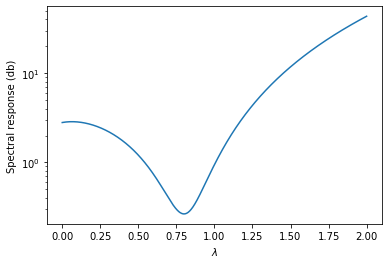

In [70]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

#### Question 19

As we said, the whole classification pipeline of the previous exercise is identical to the one we tried before: Graph filtering + Logistic regression. The only difference lies in the way we chose the filter coefficients. First we were choosing them manually, and now, we let `PyTorch` find them for us. However, if everything is correct we should be able to use this filter to construct new hand-crafted features and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor:

In [71]:
graph_gcn_filter = polynomial_graph_filter(coeff_gcn, laplacian)

Let's extract the new features by filtering the data:

In [72]:
features_gcn = graph_gcn_filter @ features.numpy()

train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression on these features:

In [73]:
# Your code here
logreg3 = create_rg(max_iter=100, C=1e1).fit(train_features_gcn, train_labels)

Finally, let's evaluate this model:

In [74]:
train_acc = logreg3.score(train_features_gcn,train_labels) #something is wrong here, it keeps giving me the same values
val_acc = logreg3.score(val_features_gcn,val_labels)
test_acc = logreg3.score(test_features_gcn,test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.9929 | Validation accuracy 0.8033 | Test accuracy 0.8150


The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?

*Your answer here*

We use a different library to apply Logistic Regression with different hyperparameters than the one used for testing during pytorch gradient descent execution. This explains that we have a different model and therefore different training results. Yet, the results are really close and comparable to our previous results while handcrafting the filter.